In [1]:
import pandas as pd
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from stress_addition_model import sam_prediction, SAM_Setting
from data_formats import read_data, ExperimentData, DoseResponseSeries
from dose_reponse_fit import ModelPredictions
from scipy.stats import beta

BETA = 3.2

def qbet(x):
    return beta.ppf(x, BETA, BETA)

def pbet(x):
    return beta.cdf(x, BETA, BETA)

In [2]:
df = pd.read_csv("beta_variations.csv", index_col=0)

mse = df.query("metric == 'mse'").iloc[:, 3:]
r2 = df.query("metric == 'r2'").iloc[:, 3:]

df = pd.concat([mse.mean(), r2.mean()], axis=1, keys=["mse", "r2"])

a = [(float(a), float(b)) for a, b in df.index.str.split("-")]

df.index = pd.MultiIndex.from_tuples(a, names=["p", "q"])
df.mse.idxmin()

(np.float64(2.4896551724137934), np.float64(1.806896551724138))

In [3]:
df.mse.sort_values().head(10)

p         q       
2.489655  1.806897    0.003909
          2.148276    0.003924
2.831034  3.172414    0.004014
          2.831034    0.004030
          3.513793    0.004052
2.489655  2.489655    0.004086
2.831034  3.855172    0.004116
          2.489655    0.004152
          4.196552    0.004194
2.148276  1.124138    0.004228
Name: mse, dtype: float64

In [4]:
df.r2.sort_values(ascending=False).head(10)


p         q       
2.831034  3.172414    0.935889
          2.831034    0.935776
          3.513793    0.935194
2.489655  1.806897    0.934404
          2.148276    0.934397
2.831034  2.489655    0.934092
          3.855172    0.934092
3.172414  4.879310    0.933772
          5.220690    0.933698
          4.537931    0.933604
Name: r2, dtype: float64

In [5]:
df.loc[2.831034482758621 , 3.1724137931034484 ]

mse    0.004014
r2     0.935889
Name: (2.831034482758621, 3.1724137931034484), dtype: float64

In [6]:
df.loc[3.1724137931034484 , 3.1724137931034484 ]

mse    0.004901
r2     0.926790
Name: (3.1724137931034484, 3.1724137931034484), dtype: float64

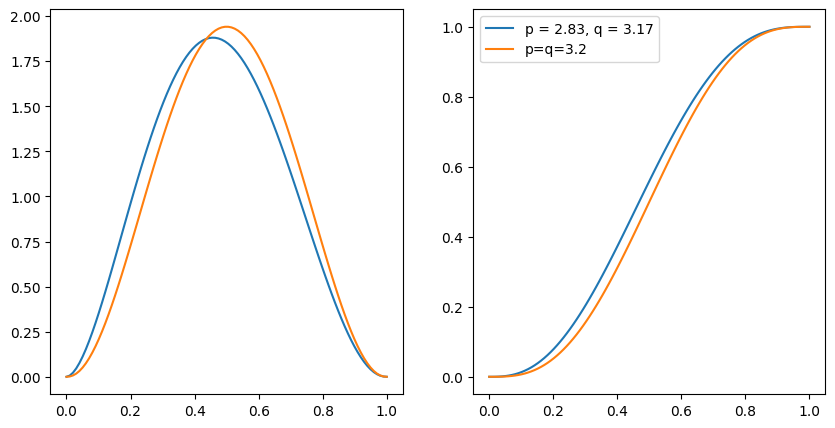

In [7]:
from scipy.stats import beta

p,q = 2.83 ,  3.17

# plot the distribution
plt.figure(figsize=(10, 5))
plt.subplot(121)
x = np.linspace(0, 1, 100)
plt.plot(x, beta.pdf(x, p, q), label = f"p = {p}, q = {q}")
plt.plot(x, beta.pdf(x, 3.2, 3.2), label = "p=q=3.2")

plt.subplot(122)
# also cdf
plt.plot(x, beta.cdf(x, p, q), label = f"p = {p}, q = {q}")
plt.plot(x, beta.cdf(x, 3.2, 3.2), label = "p=q=3.2")
plt.legend()
plt.show()

In [8]:
TRANSFORM = "williams_and_linear_interpolation"
PYTHON_DIR = "migration/python"
R_DIR = "migration/r"

In [9]:
names = []

clean_path = lambda x: os.path.basename(x).split(".")[0]

for name in glob("data/*.xlsx"):

    data = read_data(name)
    
    for i in data.additional_stress.keys():
        
        names.append(f"{clean_path(name)}_{i}_{TRANSFORM}_lmcurve.csv")
        
        

In [10]:
python_inter = set(names).intersection(os.listdir(PYTHON_DIR))
r_inter = set(names).intersection(os.listdir(R_DIR))

combined = python_inter.intersection(r_inter)
len(python_inter), len(r_inter), len(combined)

(42, 42, 42)

In [11]:
files = []
for name in glob("data/*.xlsx"):

    data = read_data(name)
    
    for i in data.additional_stress.keys():
        
        p = f"{clean_path(name)}_{i}_{TRANSFORM}_lmcurve.csv"
        
        pred_new = sam_prediction(data.main_series, data.additional_stress[i], data.meta, SAM_Setting(beta_q=3.17, beta_p=2.83, param_d_norm=True, stress_form="substract"))
        pred_old = sam_prediction(data.main_series, data.additional_stress[i], data.meta, SAM_Setting(param_d_norm=False, stress_form="only_stress", beta_p = 3.2, beta_q = 3.2))
        
        if p in combined:
            files.append((data, i, p, pred_new, pred_old[2]))
        

0.06000000000000005 0.94
0.10001000000000004 0.89999
0.19066666666666665 0.8093333333333333
0.5106666666666666 0.4893333333333334
0.5786666666666667 0.42133333333333334
0.2001776666666667 0.7998223333333333
0.06666667000000004 0.93333333
0.11111110999999996 0.88888889
0.11111110999999996 0.88888889
0.15555556000000004 0.84444444
0.4222222200000001 0.5777777799999999
0.46666666999999995 0.53333333
0.51111111 0.48888889
0.041730000000000045 0.95827
0.13046689999999994 0.8695331000000001
0.04291999999999996 0.95708
0.12231999999999998 0.87768
0.20138888888888895 0.798611111111111
0.07999999999999996 0.92
0.24869565217391298 0.751304347826087
0.19999999999999996 0.8
0.1142857100000001 0.8857142899999999
0.28888889000000006 0.7111111099999999
0.020999999999999908 0.9790000000000001
0.030999999999999917 0.9690000000000001
0.030999999999999917 0.9690000000000001
0.010000000000000009 0.99
0.07774999999999999 0.92225
0.04200000000000004 0.958
0.052000000000000046 0.948
0.04200000000000004 0.958

In [12]:
data,stress, path, (main_fit, stress_fit, sam_sur, sam_stress), sam_old = files[2]

main_fit: ModelPredictions
stress_fit: ModelPredictions

data: ExperimentData
py = pd.read_csv(f"{PYTHON_DIR}/{path}")
r = pd.read_csv(f"{R_DIR}/{path}")

py

Concentration  Survival_A  Survival_B        SAM         EA         CA  \
0        1.000000   61.003355   60.625322  59.700251  60.639717  60.545388   
1        1.057357   60.998347   60.619230  59.663020  60.634738  60.536051   
2        1.118004   60.992925   60.612641  59.624146  60.629349  60.526126   
3        1.182129   60.987056   60.605515  59.583546  60.623514  60.515574   
4        1.249932   60.980702   60.597808  59.541129  60.617198  60.504352   
..            ...         ...         ...        ...        ...        ...   
95     200.010845    9.369146    7.227255   3.308850   9.313297   8.936875   
96     211.482853    8.024850    6.074772   2.572263   7.977015   7.646043   
97     223.612860    6.786048    5.034181   1.943203   6.745597   6.458314   
98     236.438607    5.659538    4.108349   1.419330   5.625802   5.379894   
99     250.000000    4.649779    3.297631   0.995720   4.622061   4.414720   

    LC_SAM_Concentration  LC_SAM_Survival  Stress_A  Stress_B  
0              10.821722            54.63  0.053439  0.095773  
1              66.181904            30.35  0.054822       NaN  
2                    NaN              NaN  0.056242       NaN  
3                    NaN              NaN  0.057700       NaN  
4                    NaN              NaN  0.059197       NaN  
..                   ...              ...       ...       ...  
95                   NaN              NaN  0.700931       NaN  
96                   NaN              NaN  0.718280       NaN  
97                   NaN              NaN  0.735642       NaN  
98                   NaN              NaN  0.752958       NaN  
99                   NaN              NaN  0.770169       NaN  

[100 rows x 10 columns]

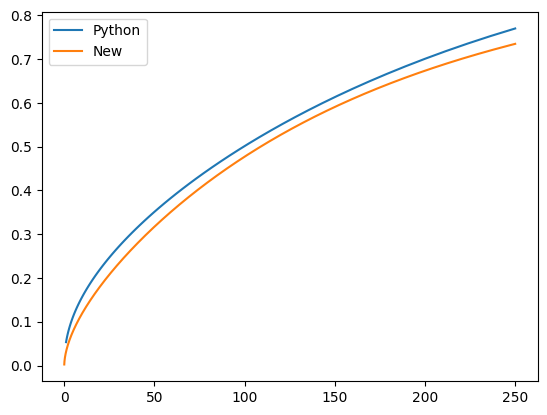

In [13]:
plt.plot(py.Concentration, py.Stress_A, label="Python")
plt.plot(main_fit.concentration_curve, main_fit.stress_curve, label="New")
plt.legend()
plt.show()

In [14]:
from stress_survival_conversion import survival_to_stress, stress_to_survival
additional_stress = survival_to_stress(stress_fit.optim_param["d"] / main_fit.optim_param["d"])
additional_stress

np.float64(0.09577326210915314)

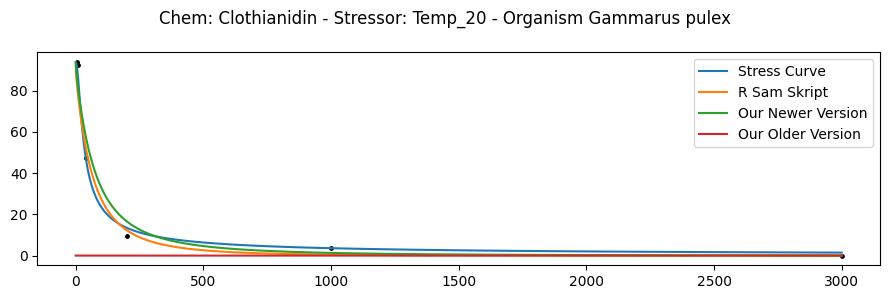

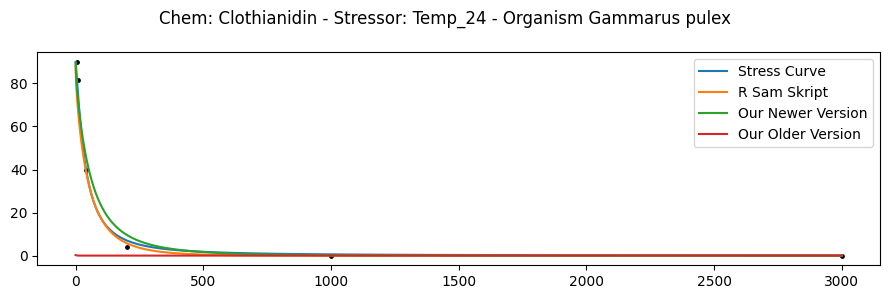

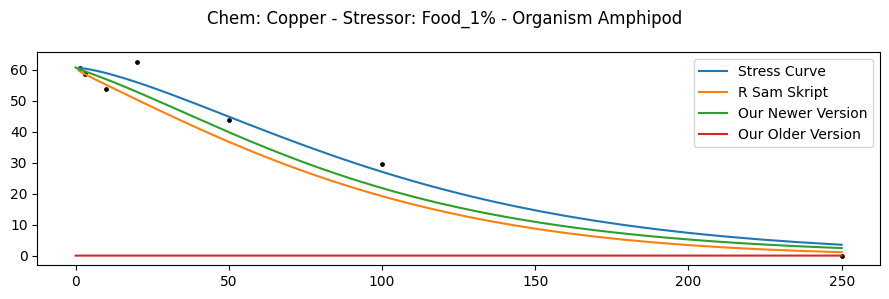

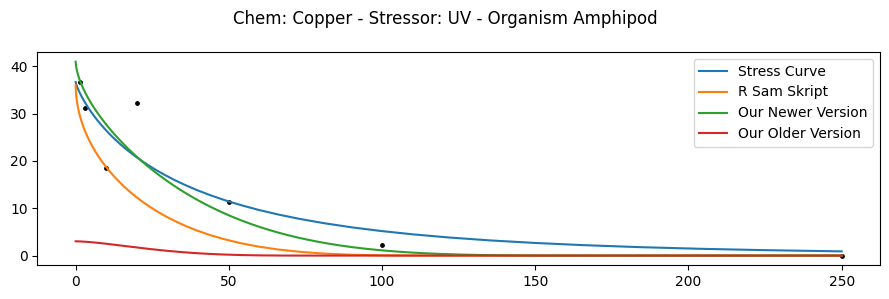

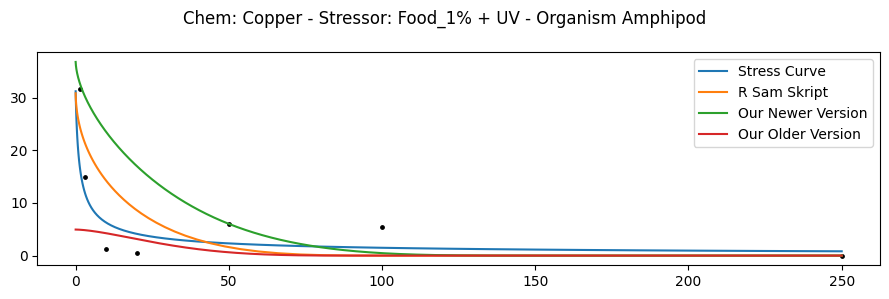

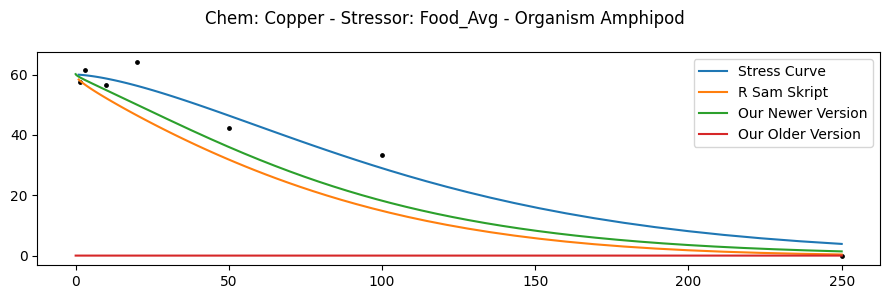

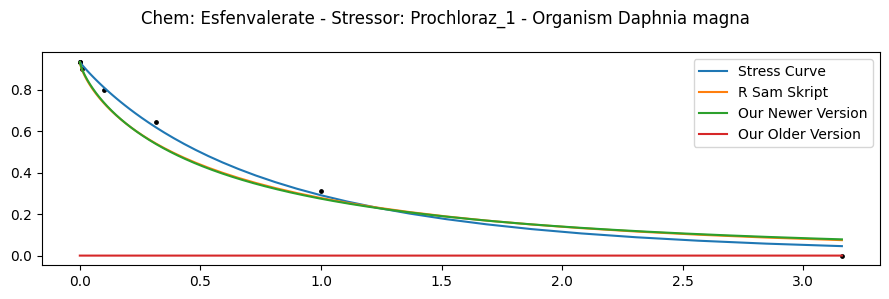

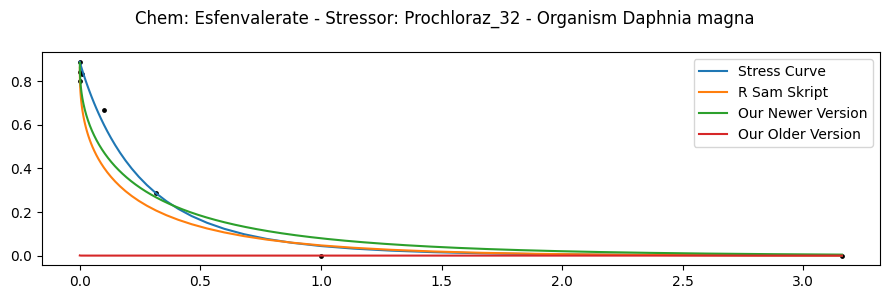

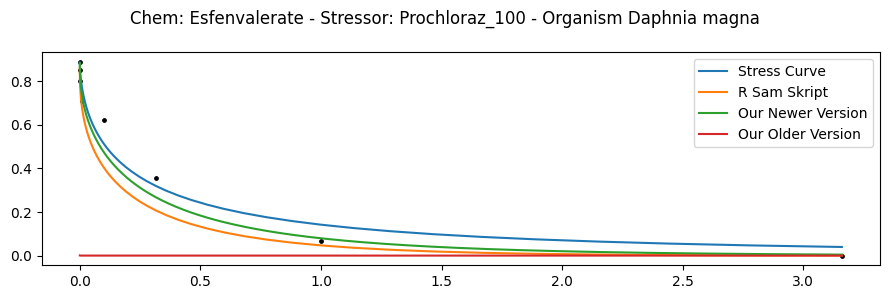

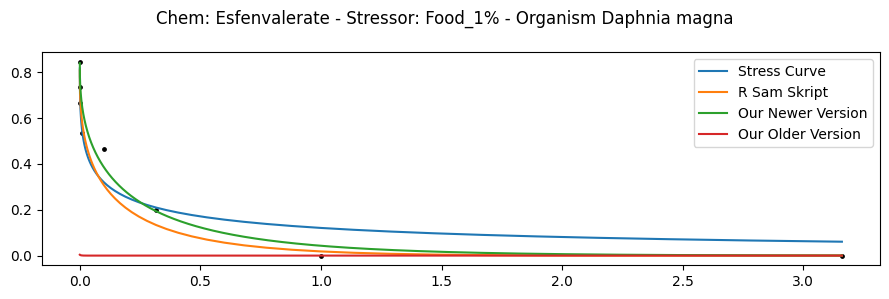

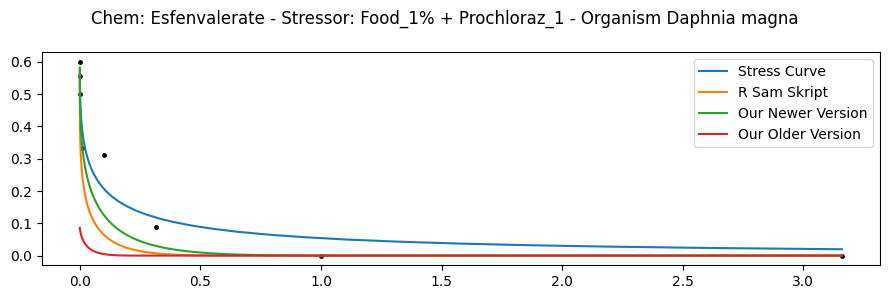

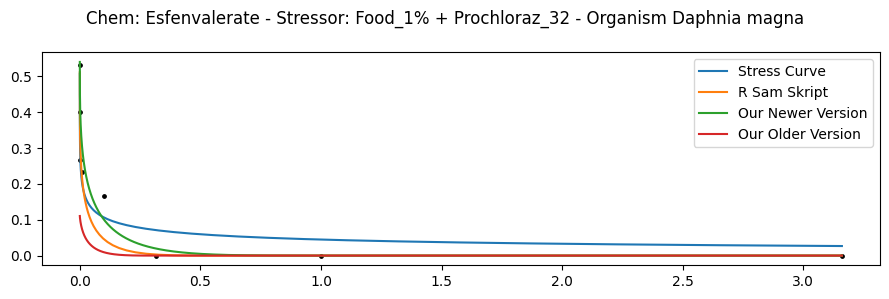

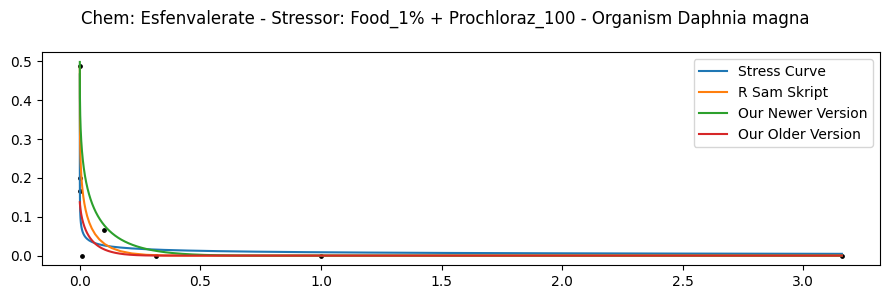

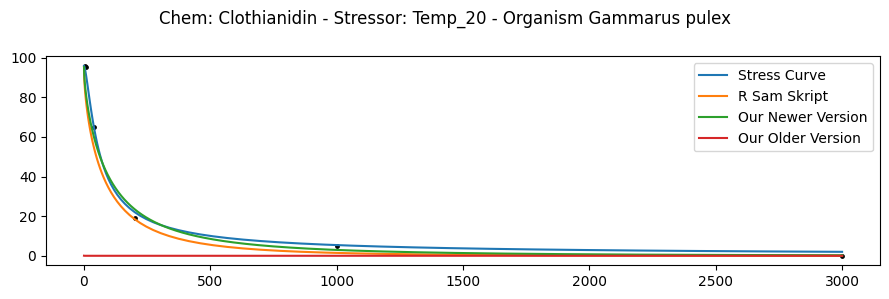

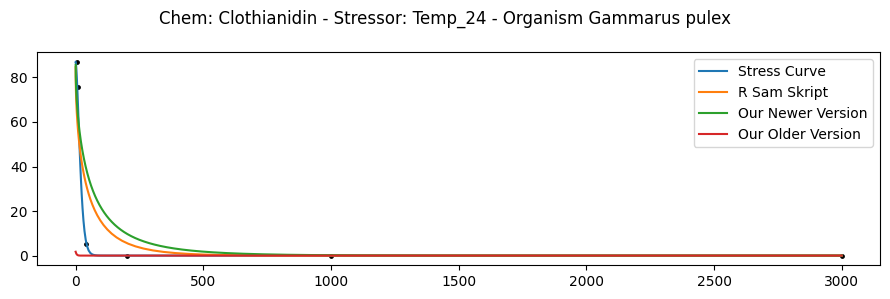

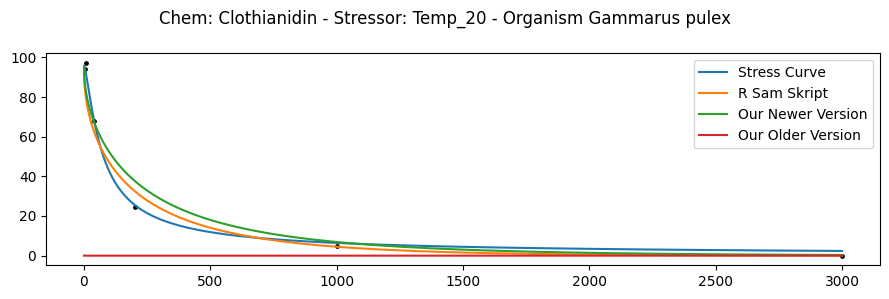

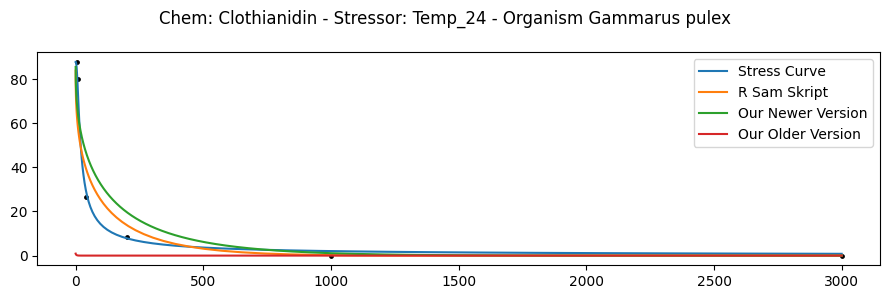

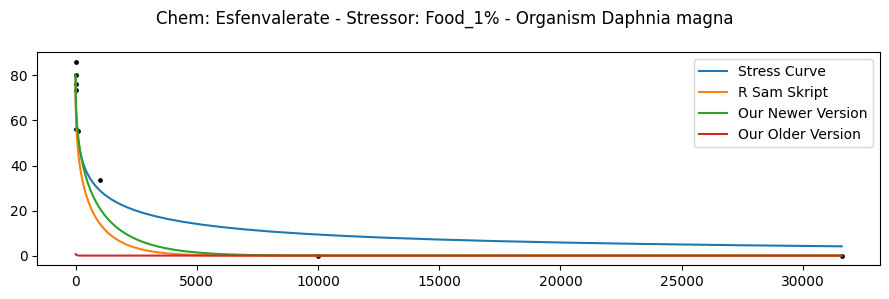

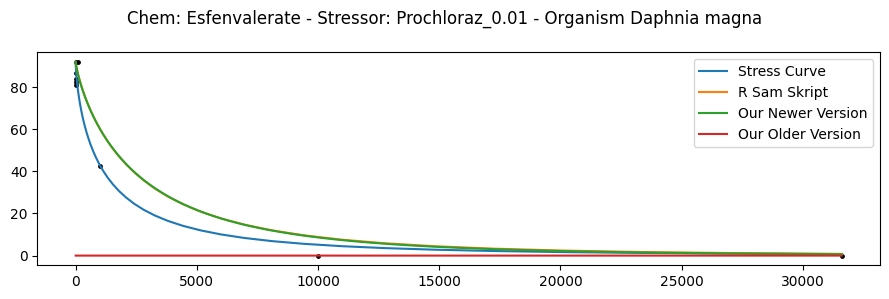

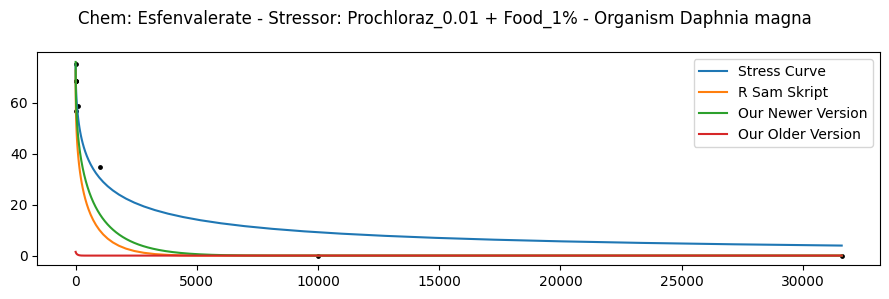

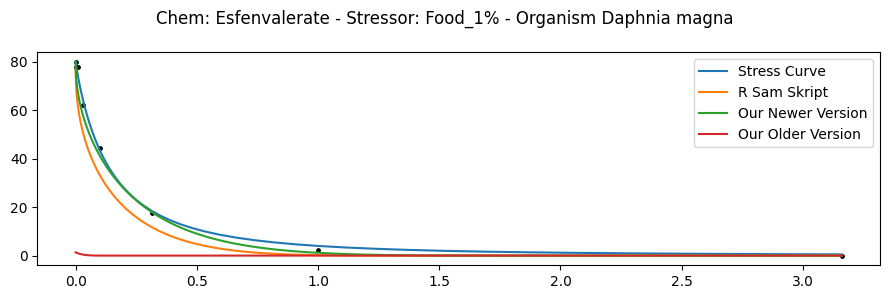

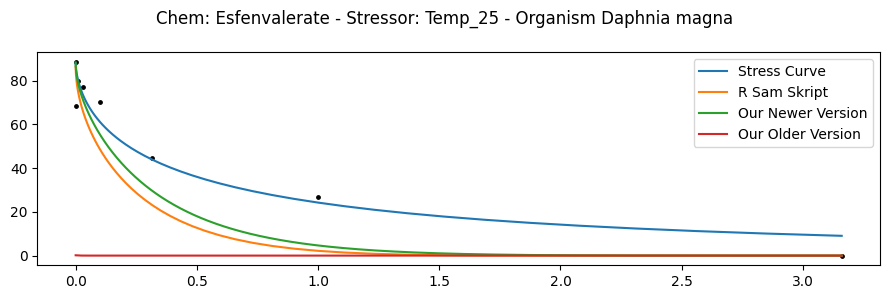

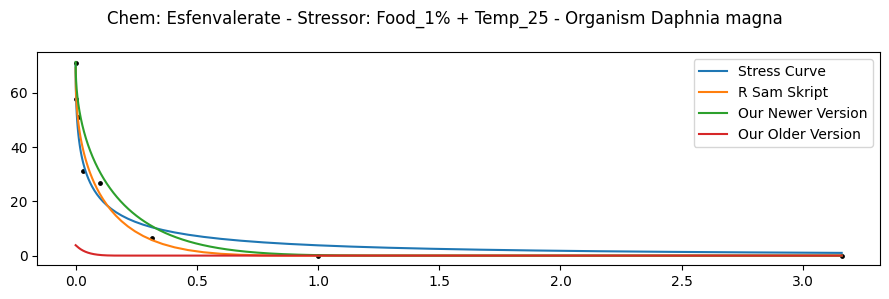

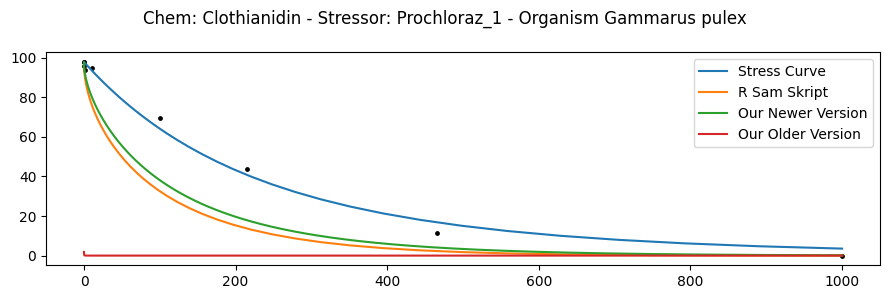

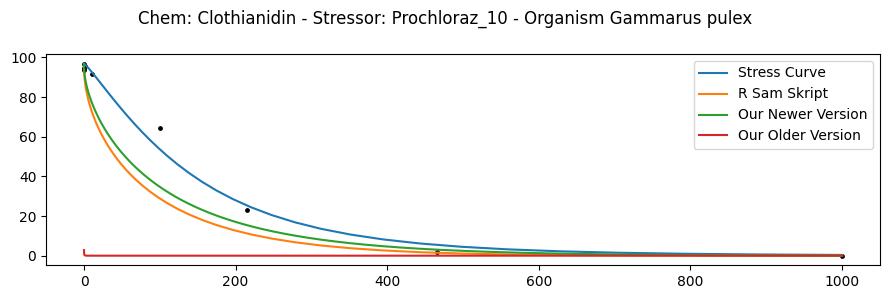

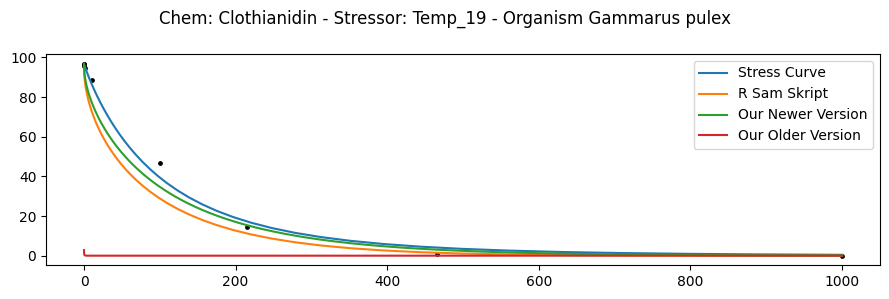

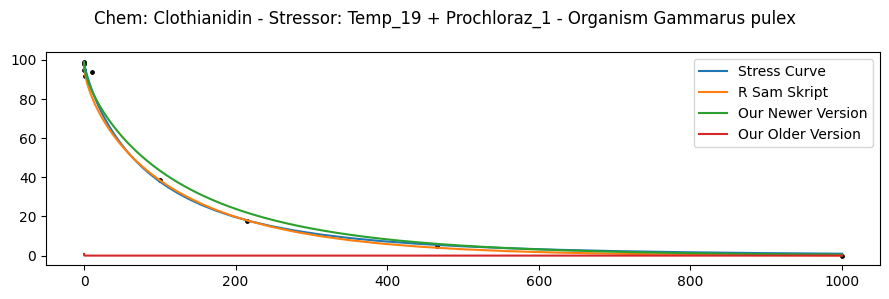

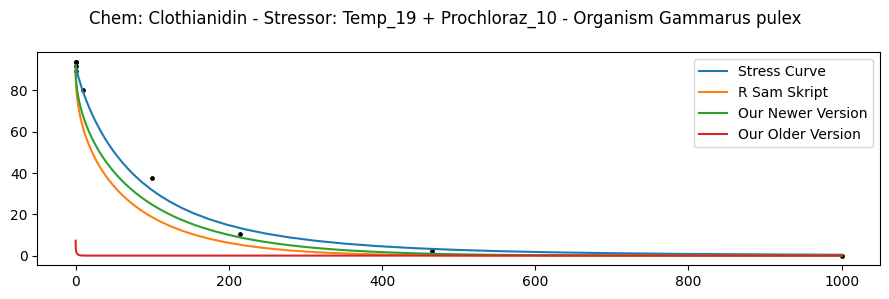

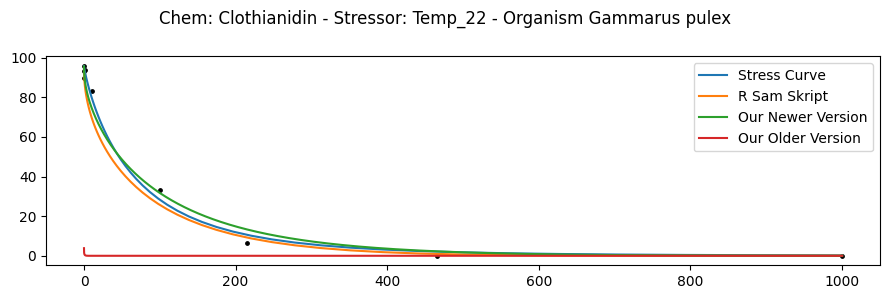

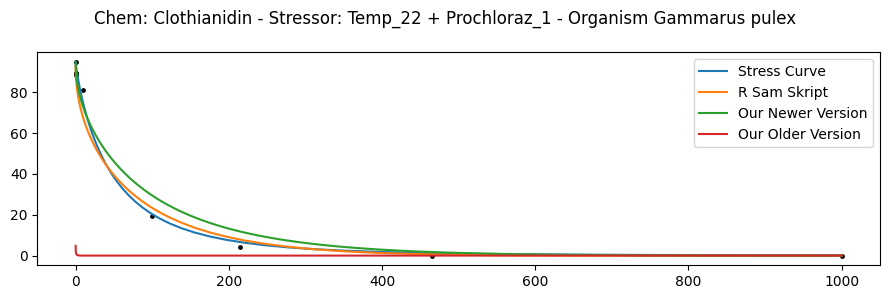

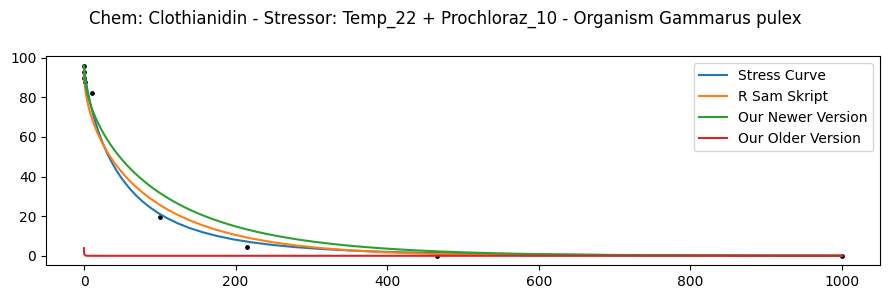

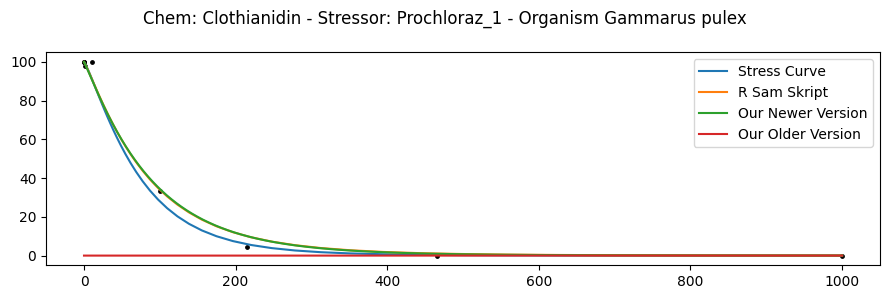

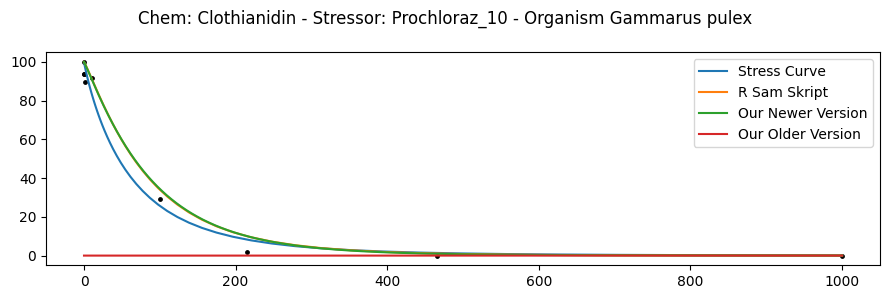

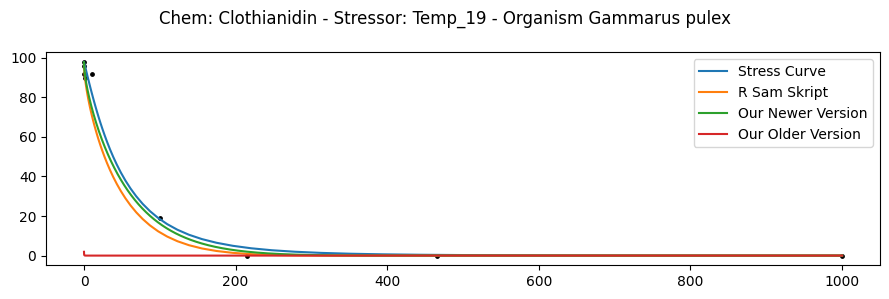

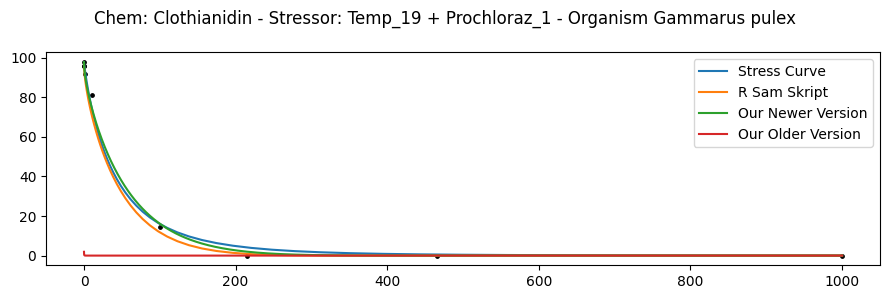

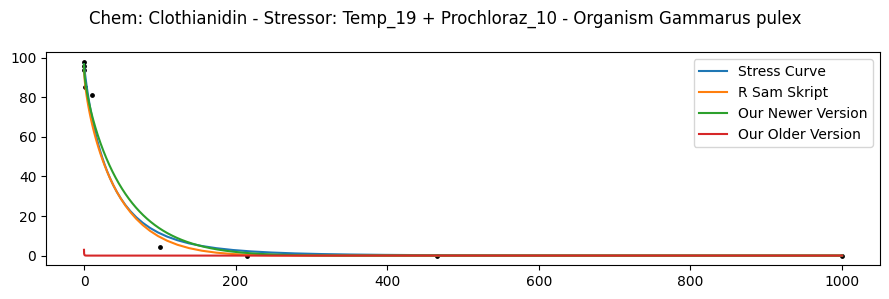

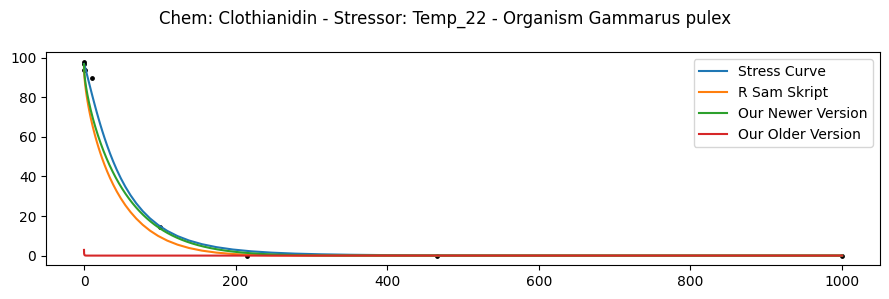

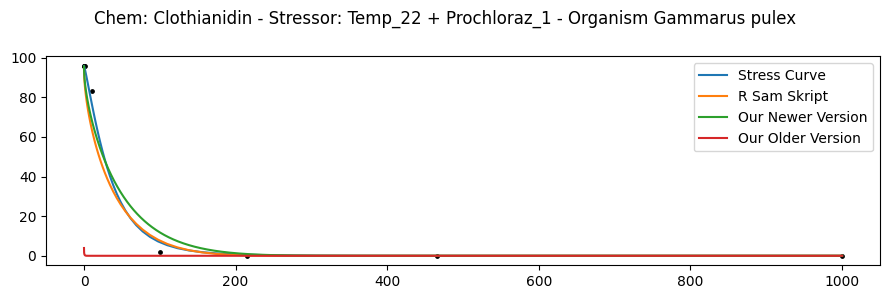

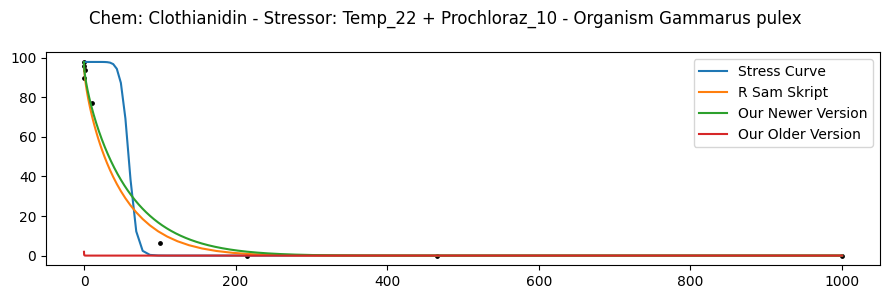

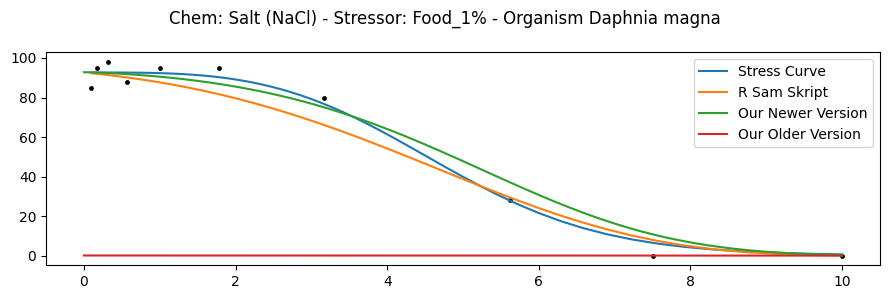

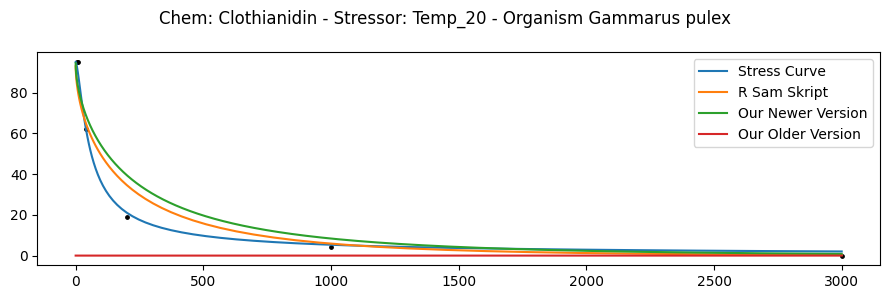

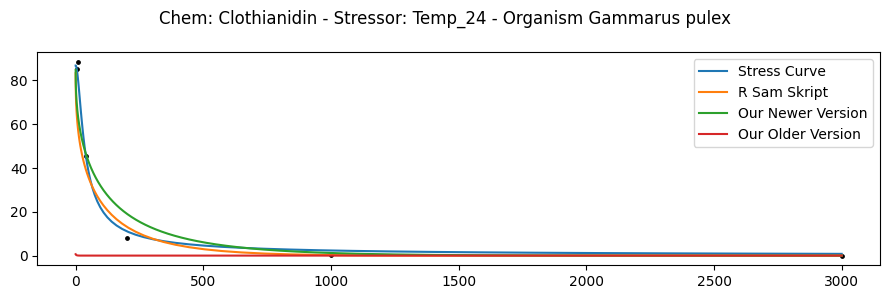

In [15]:
for data,stress, path, (main_fit, stress_fit, sam_sur, sam_stress), samn_old in files:

    main_fit: ModelPredictions
    stress_fit: ModelPredictions

    data: ExperimentData
    py = pd.read_csv(f"{PYTHON_DIR}/{path}")
    r = pd.read_csv(f"{R_DIR}/{path}")


    fig = plt.figure(figsize=(9, 3))


    # plt.scatter(data.main_series.concentration, data.main_series.survival_rate, label = "Control", s= 6)
    # plt.plot(main_fit.concentration_curve ,main_fit.survival_curve, label='Control', )
    
    
    series = data.additional_stress[stress]
    plt.scatter(series.concentration, series.survival_rate, c = "black", s= 6)
    plt.plot(r['Concentration'], r['Survival_B'], label='Stress Curve', )

    plt.plot(r['Concentration'], r['SAM'], label='R Sam Skript', )
    plt.plot(stress_fit.concentration_curve ,sam_sur, label='Our Newer Version', )
    plt.plot(stress_fit.concentration_curve ,samn_old, label='Our Older Version', )

    plt.suptitle(f"Chem: {data.meta.chemical} - Stressor: {stress} - Organism {data.meta.organism}")
    plt.legend()
    plt.tight_layout()
    
    save_path = f'migration/new/{path.replace("_williams_and_linear_interpolation_lmcurve.csv", "")}.png'
    plt.savefig(save_path)
    
    plt.show()
    plt.close()

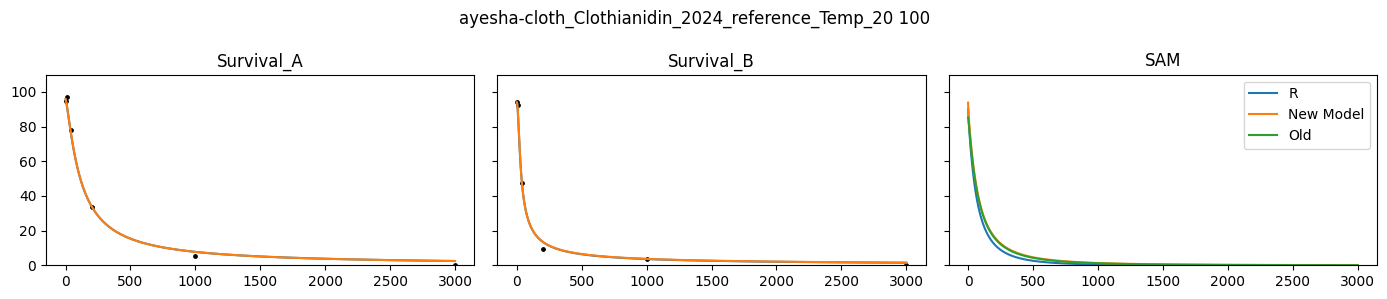

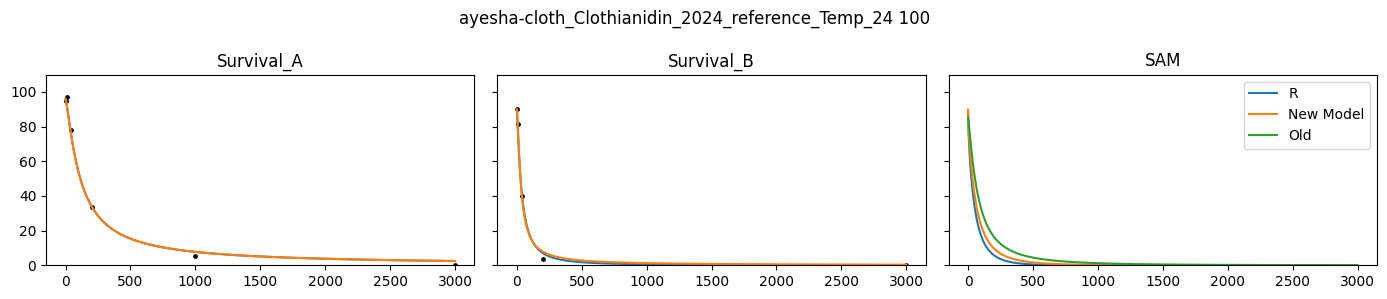

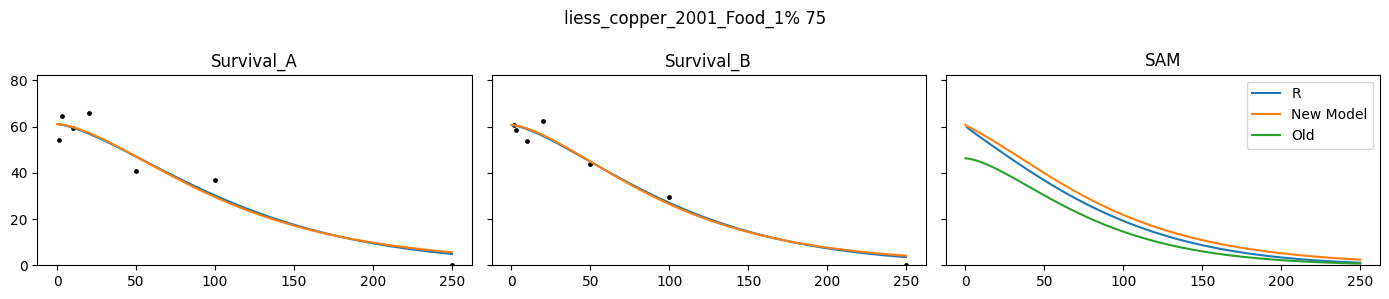

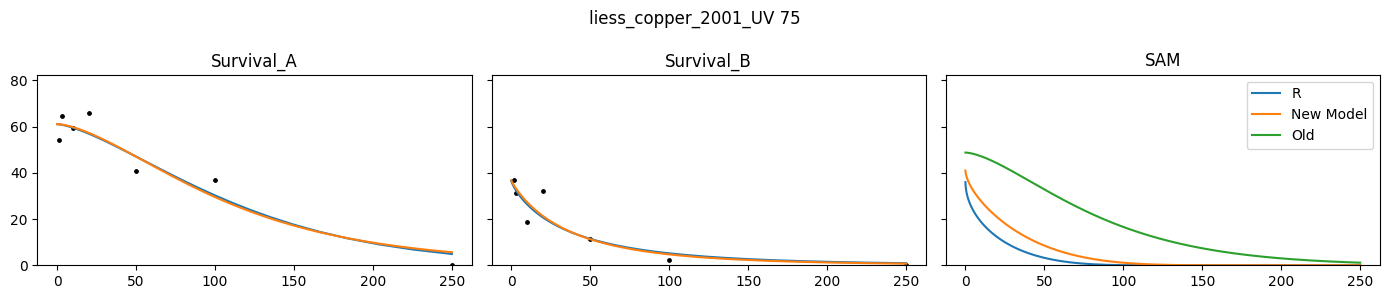

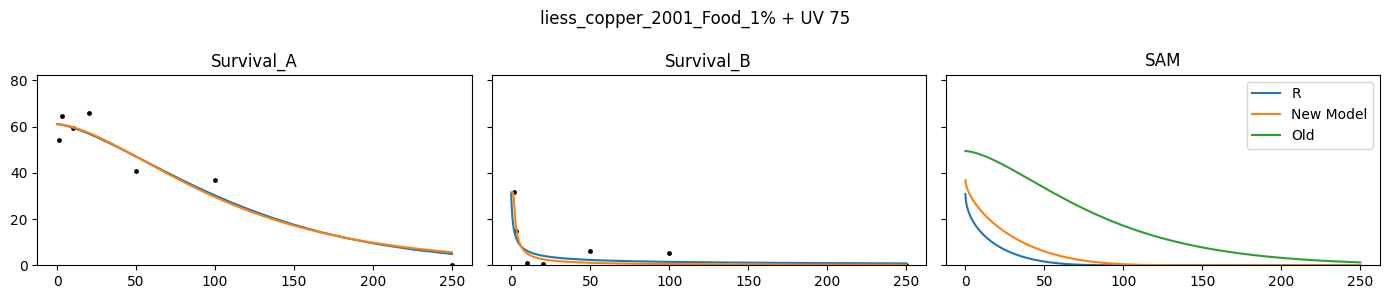

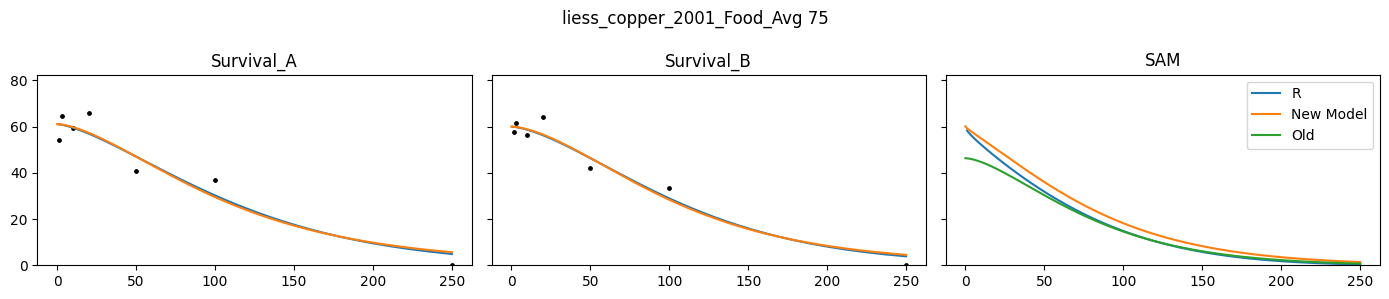

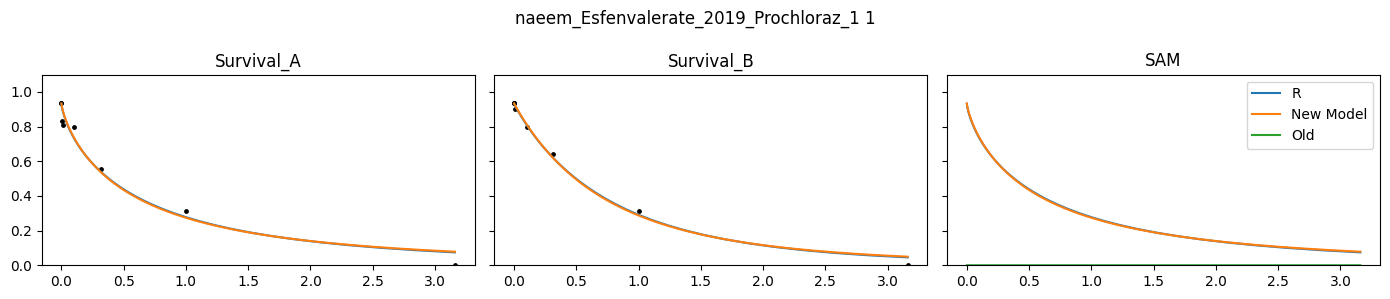

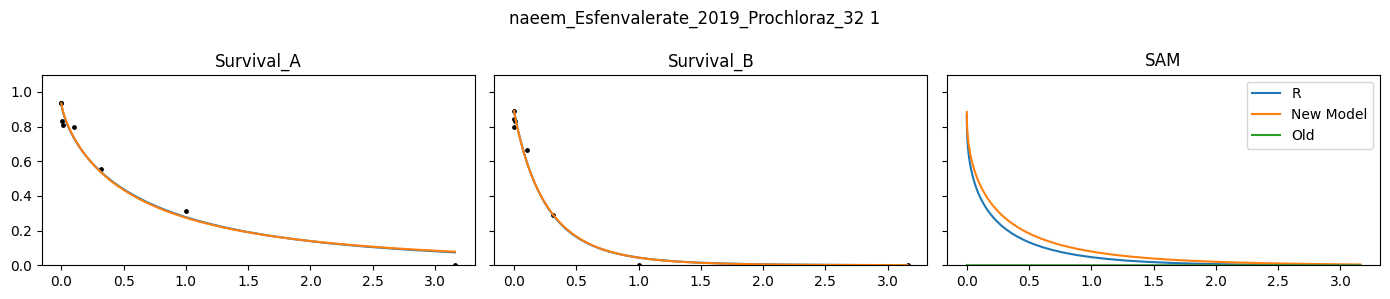

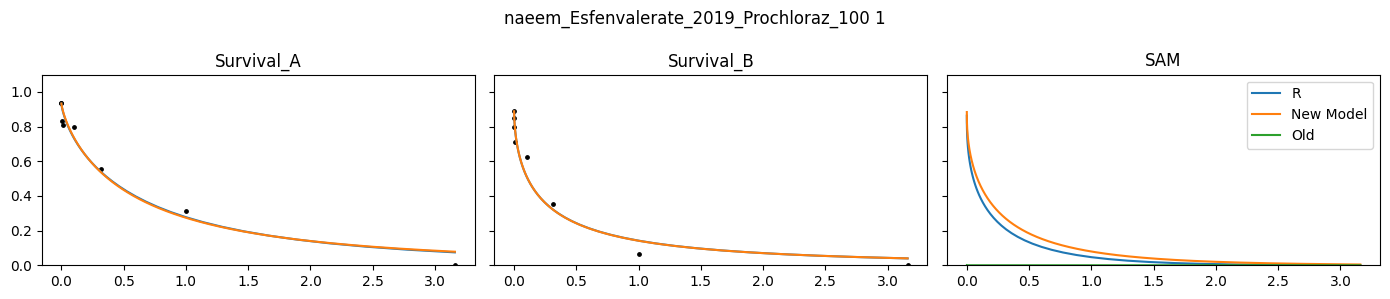

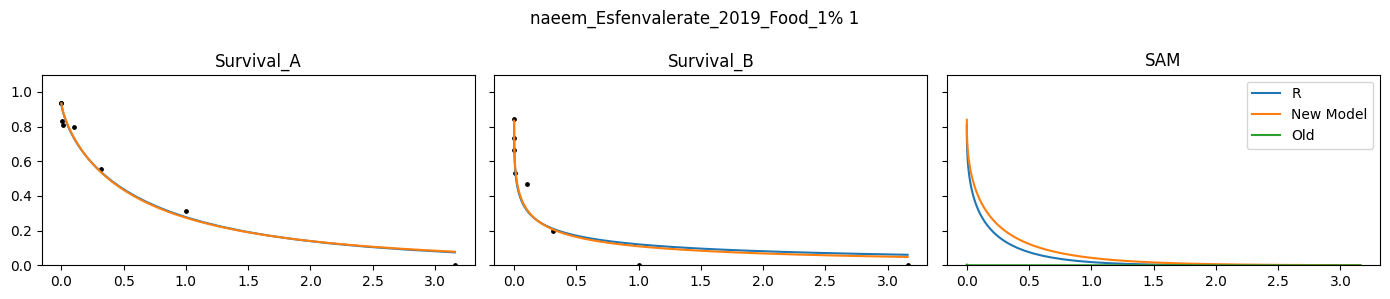

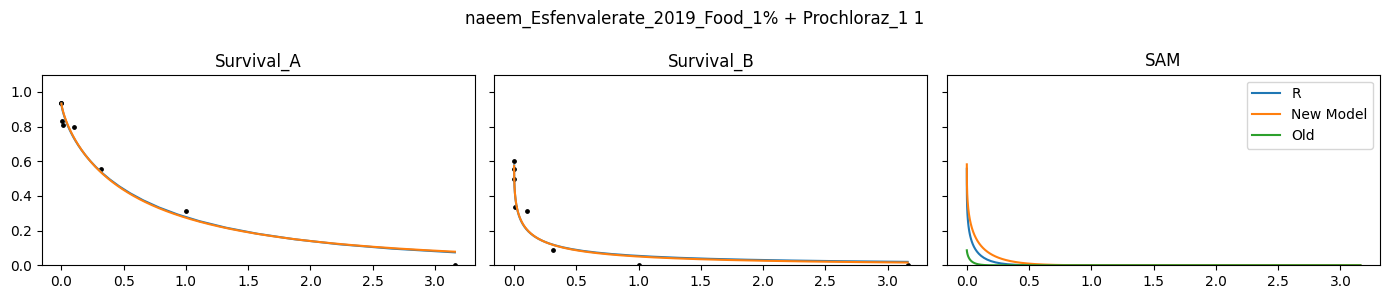

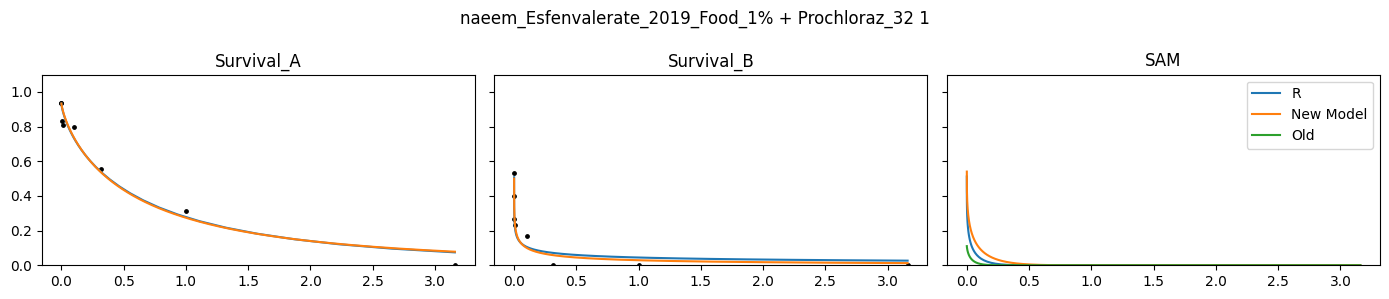

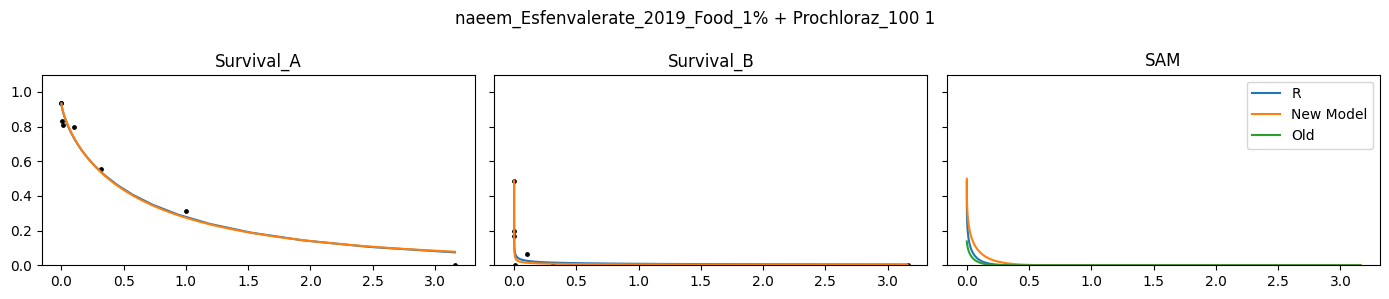

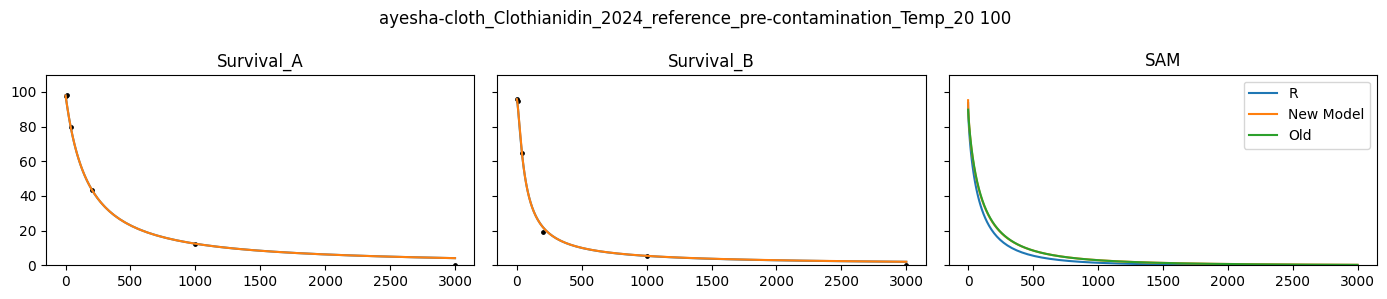

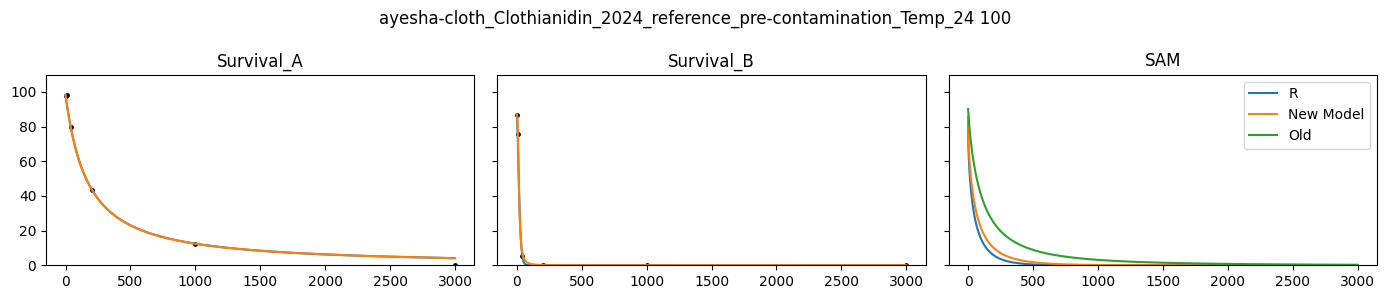

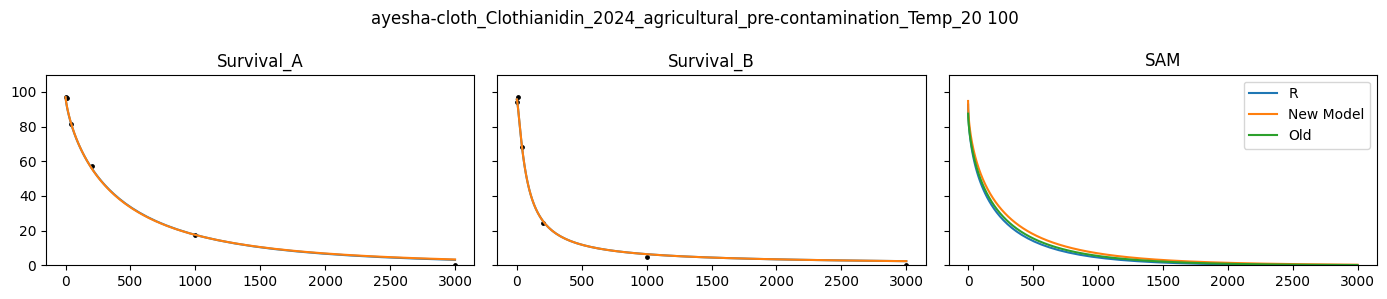

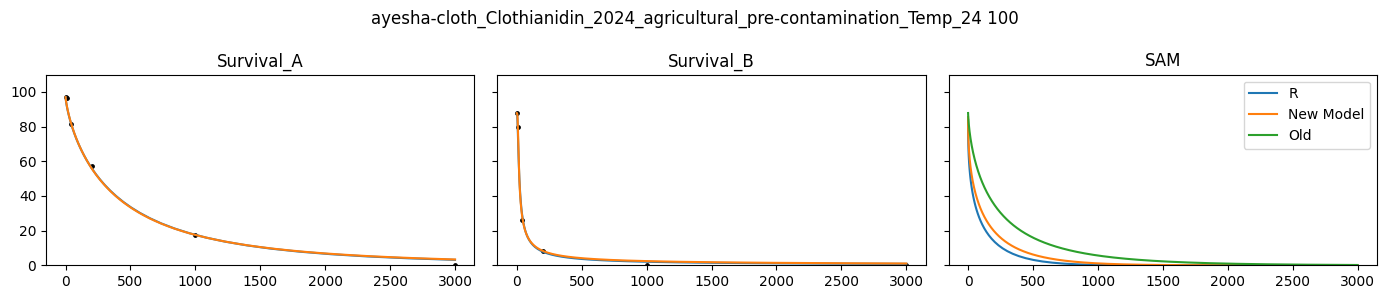

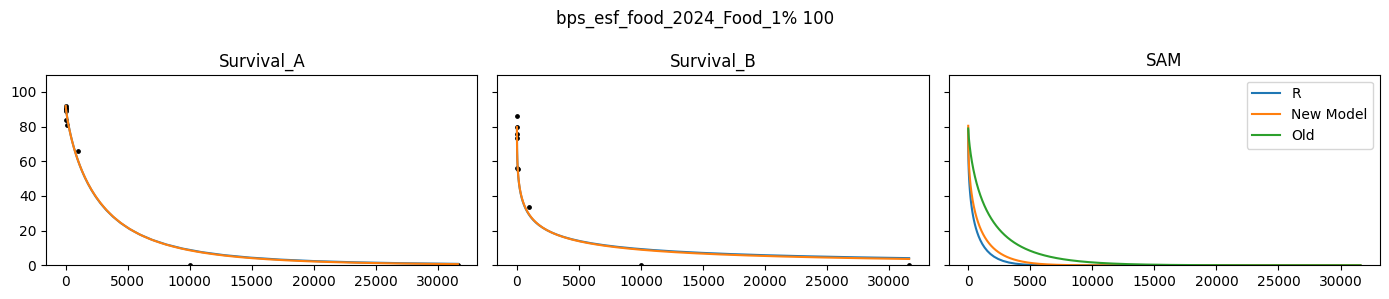

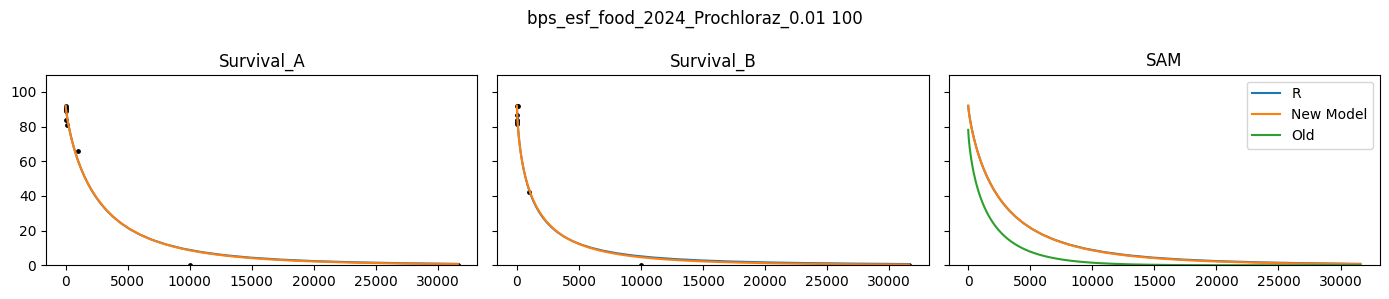

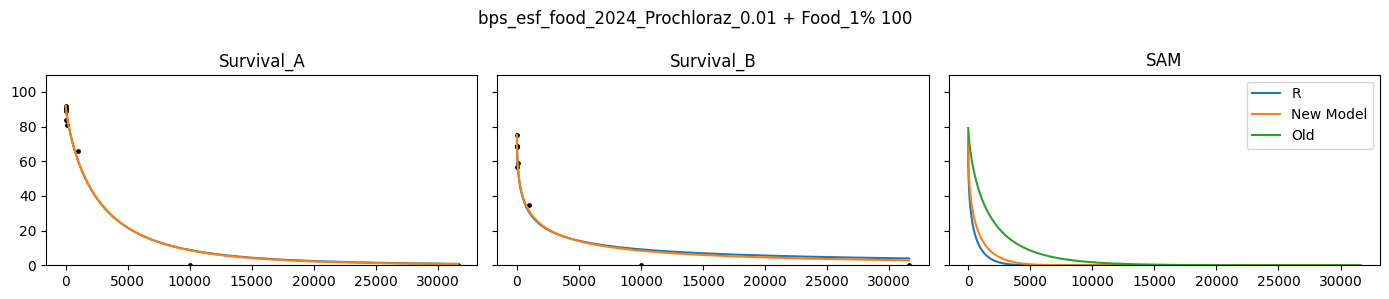

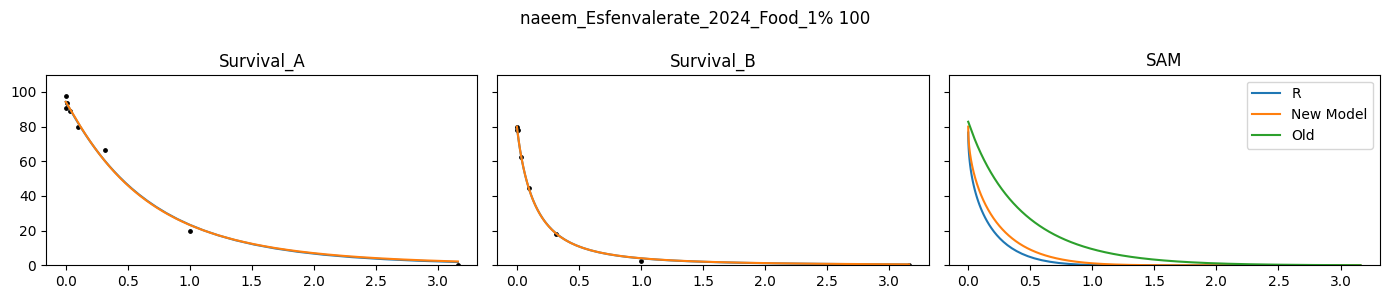

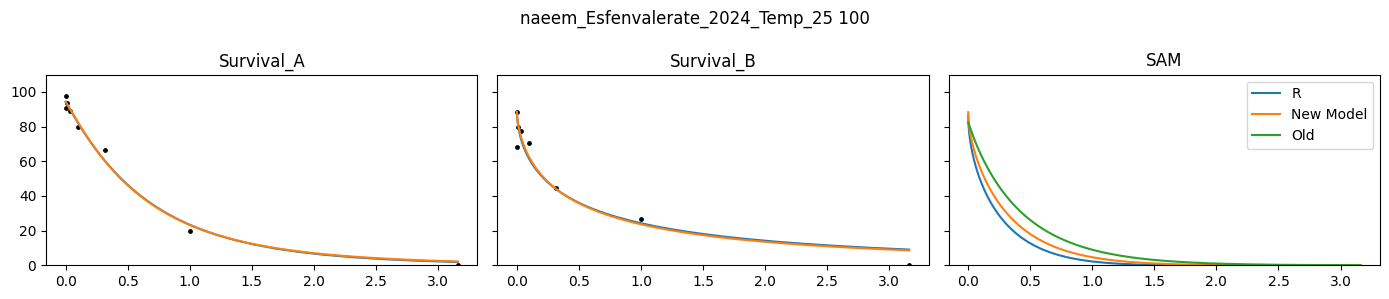

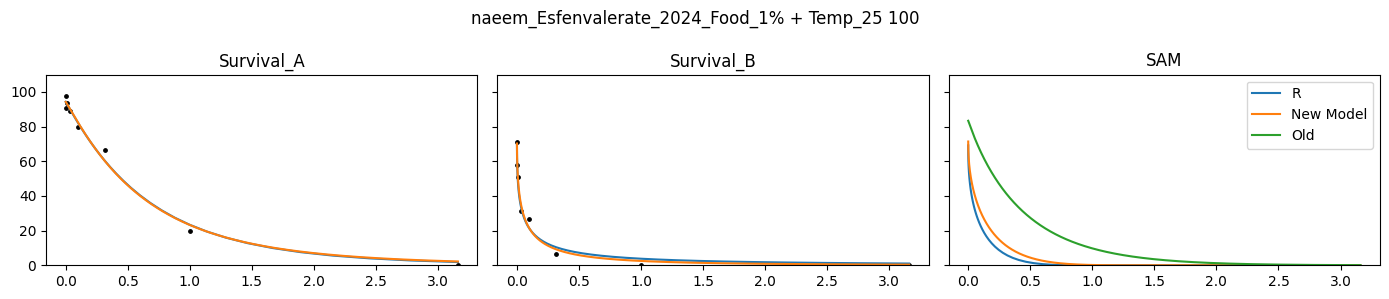

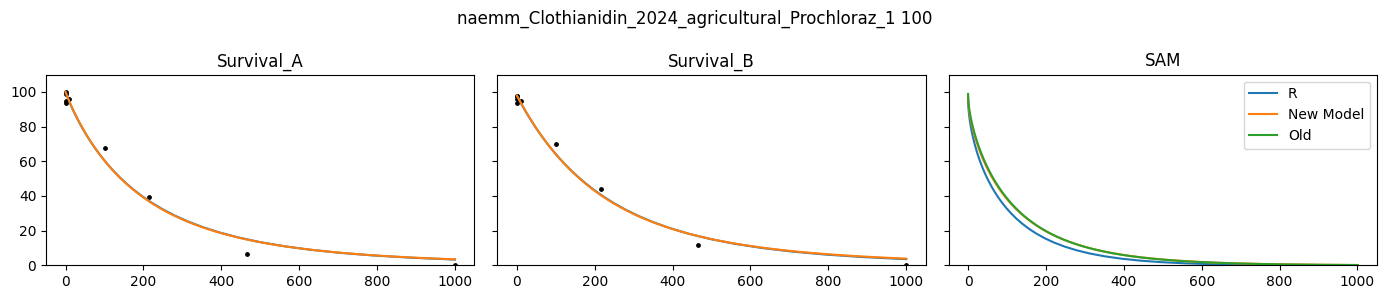

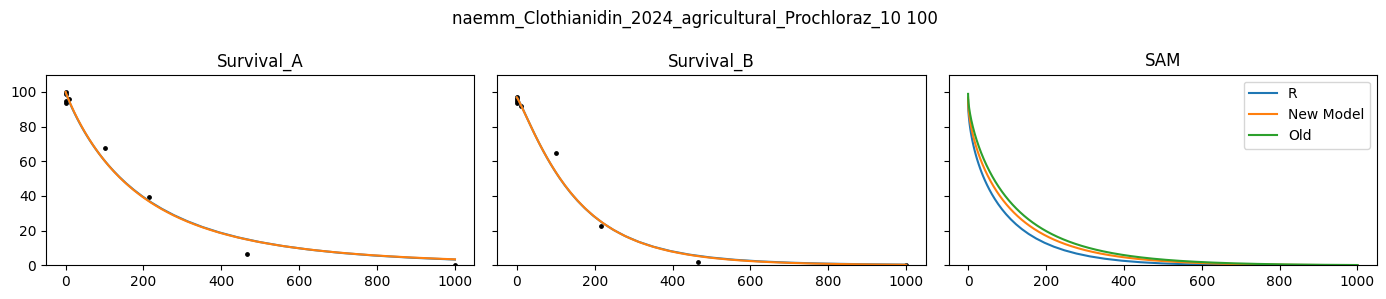

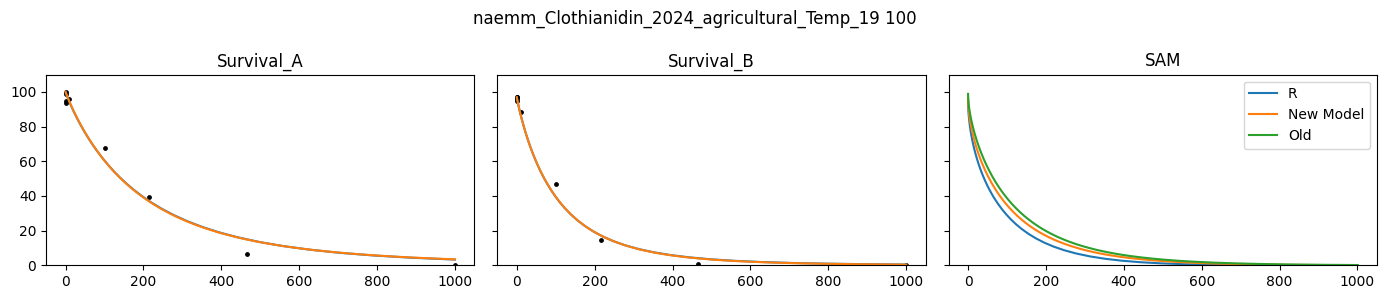

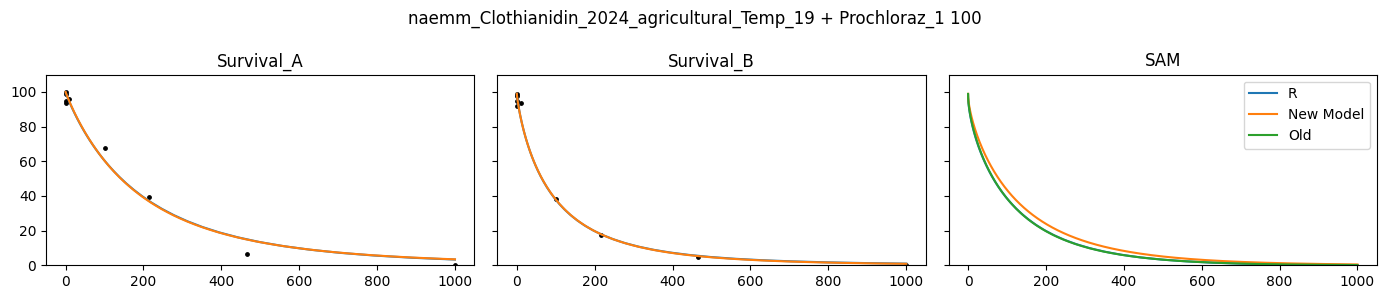

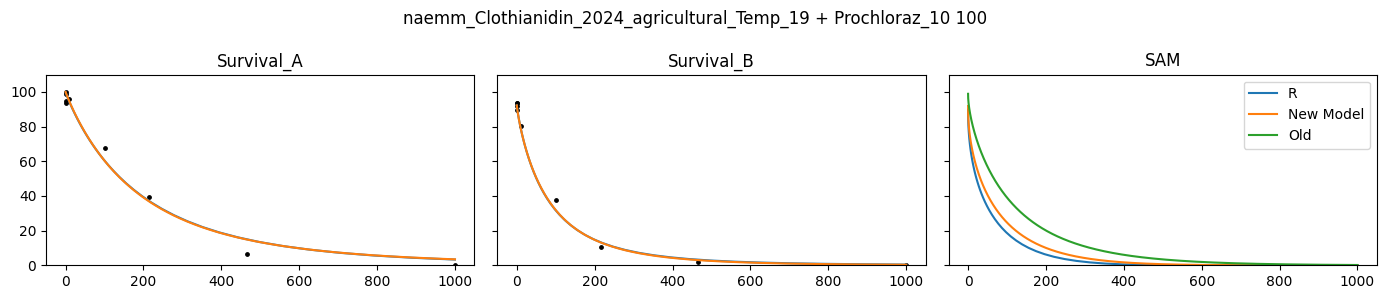

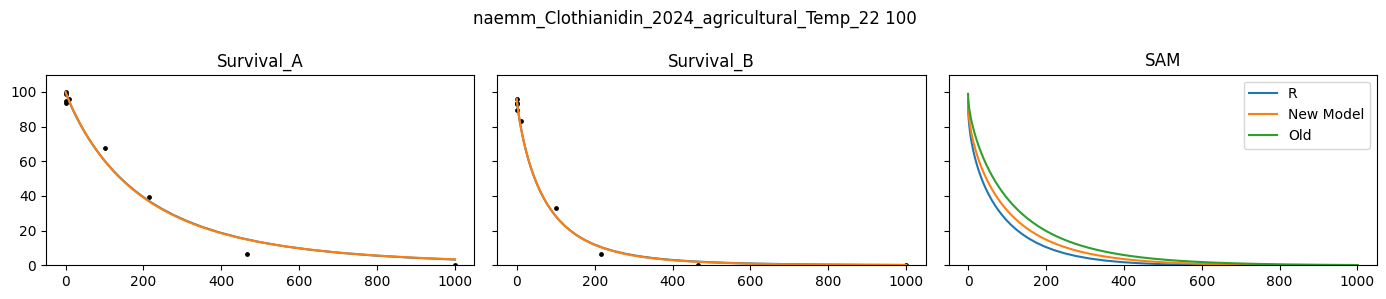

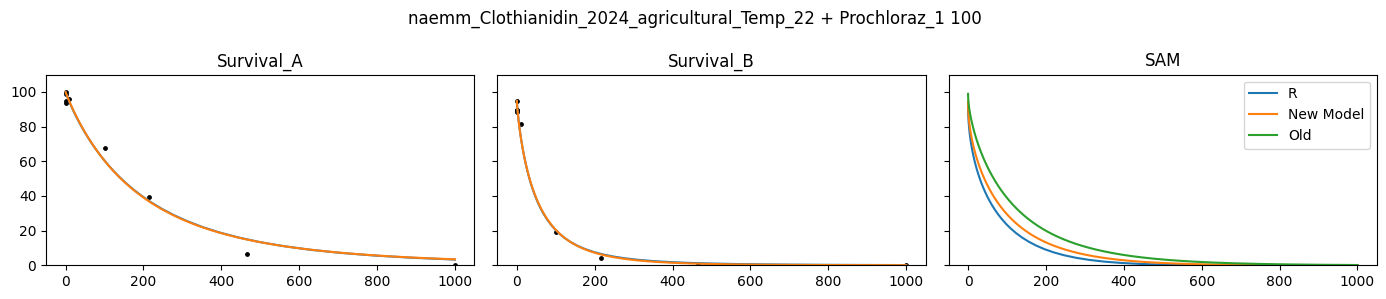

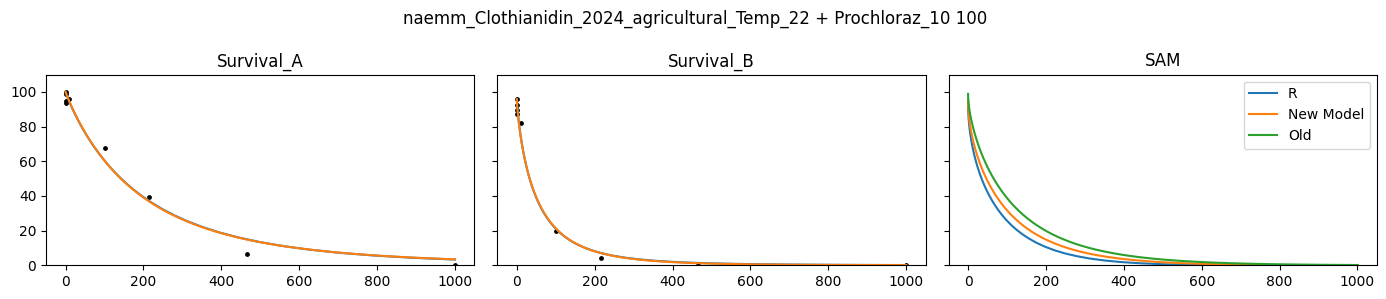

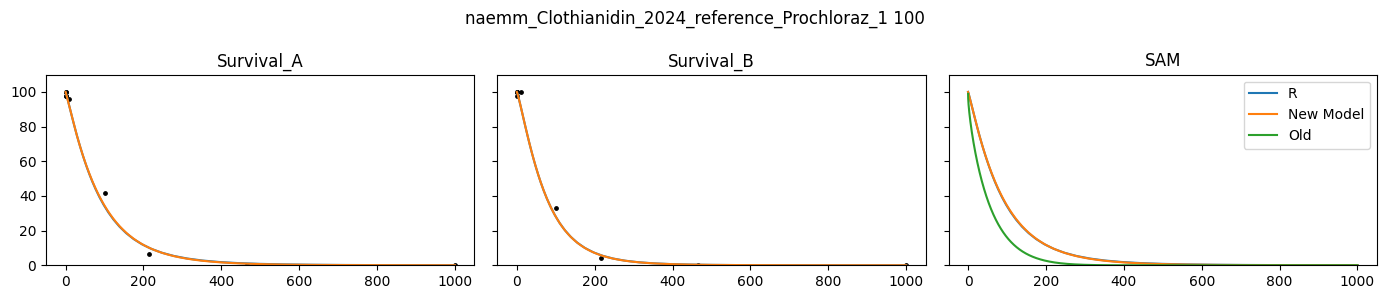

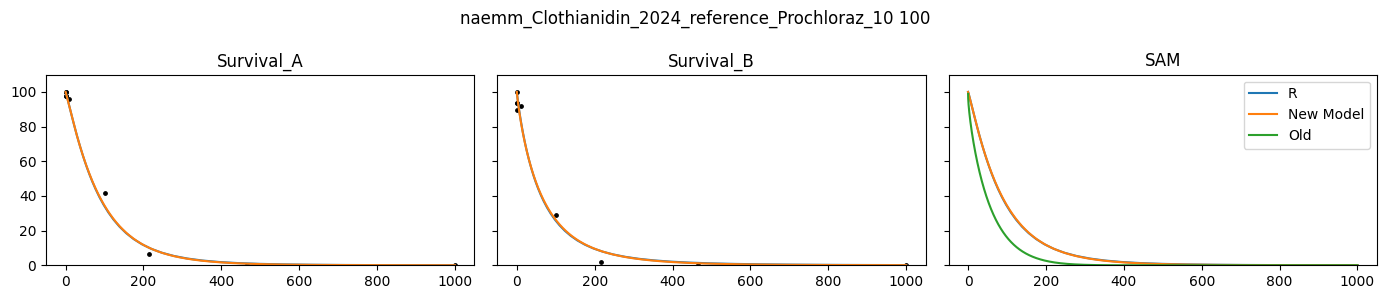

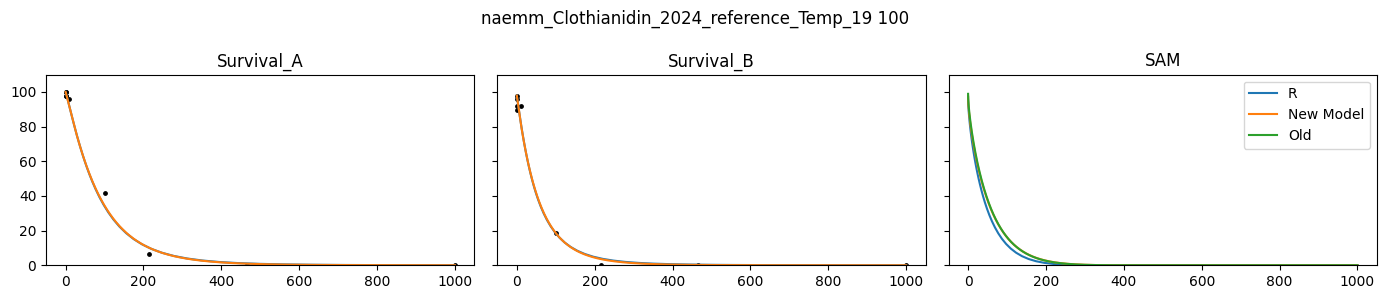

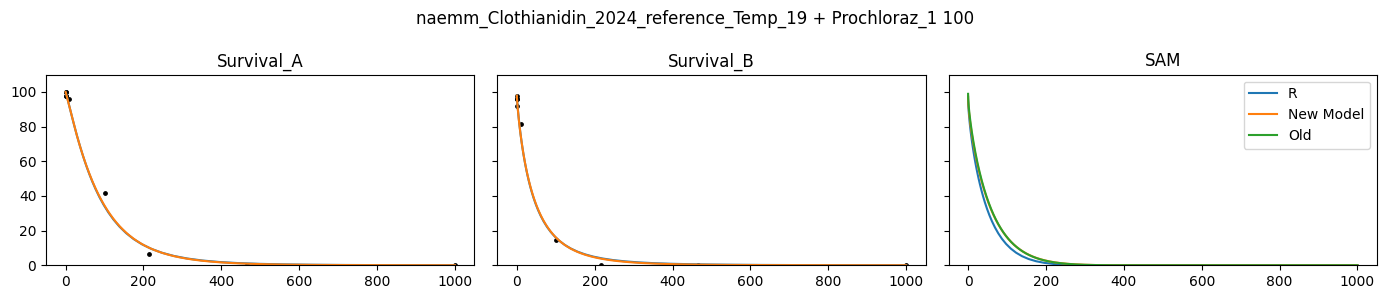

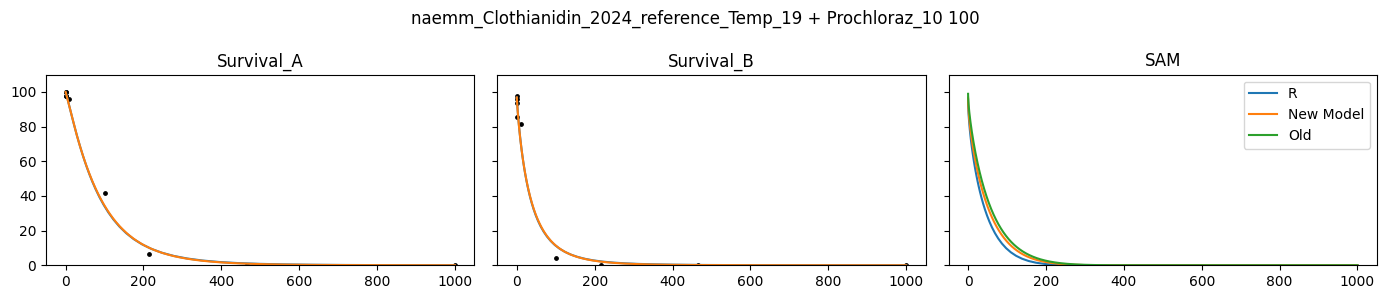

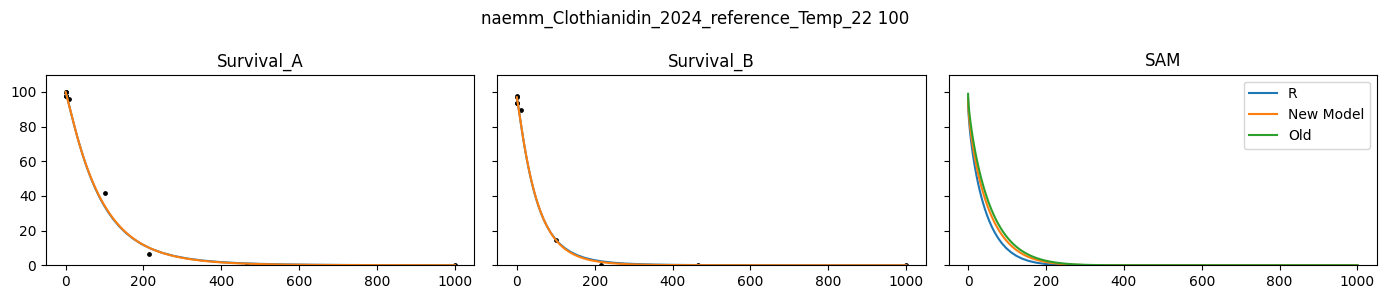

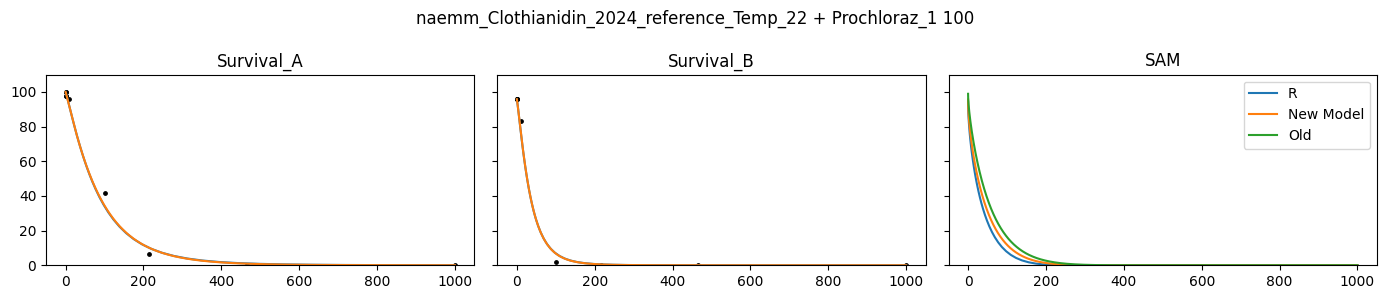

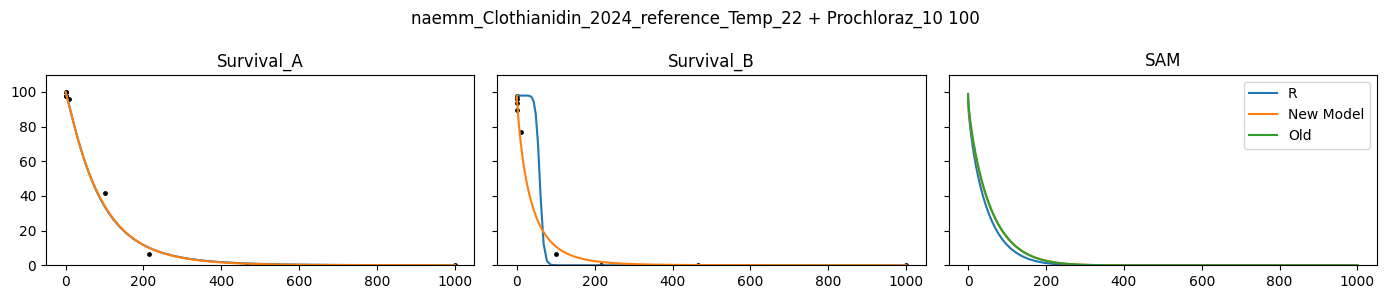

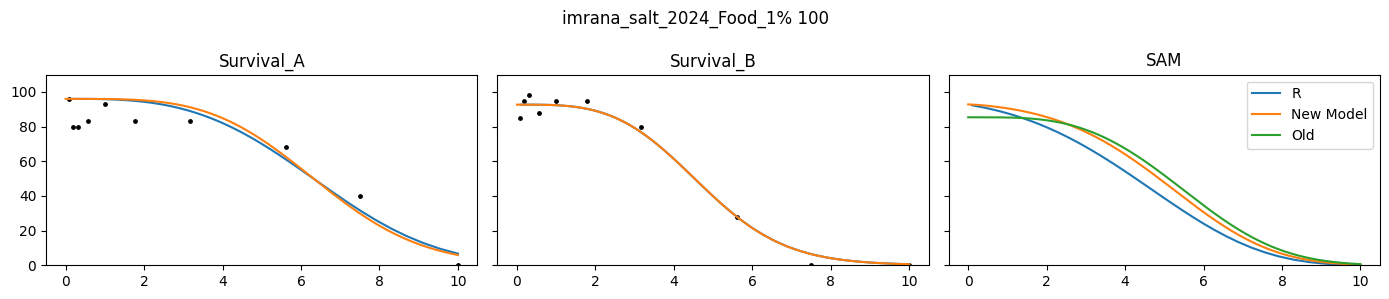

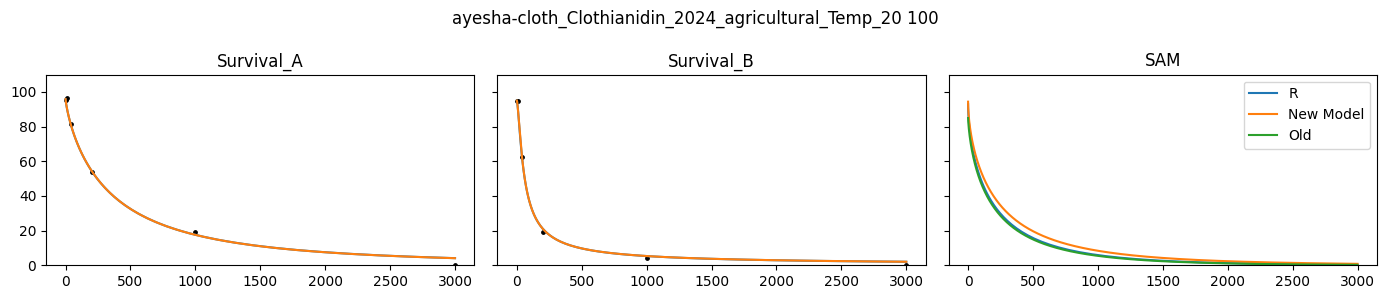

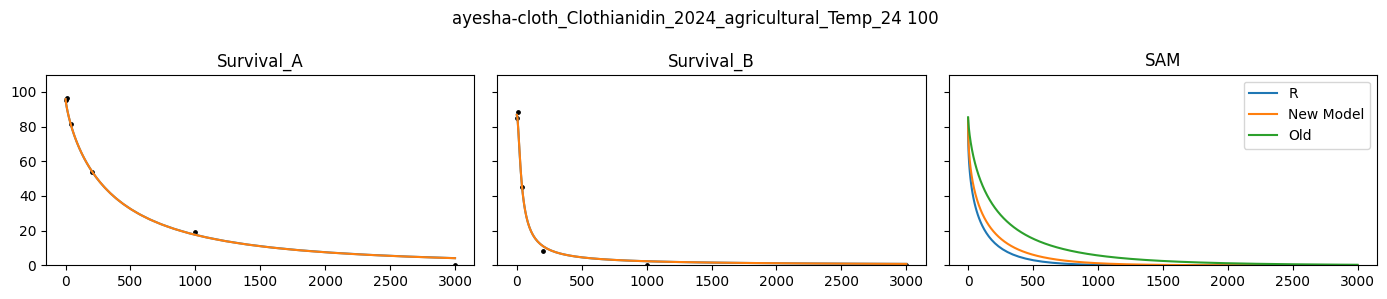

In [50]:
for data,stress, path, (main_fit, stress_fit, sam_sur, sam_stress), samn_old in files:

    main_fit: ModelPredictions
    stress_fit: ModelPredictions

    data: ExperimentData
    py = pd.read_csv(f"{PYTHON_DIR}/{path}")
    r = pd.read_csv(f"{R_DIR}/{path}")

    fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(14, 3))

    ax[0].scatter(data.main_series.concentration, data.main_series.survival_rate, c = "black", s= 6)
    ax[0].plot(r['Concentration'], r['Survival_A'], label='R', )
    # ax[0].plot(py['Concentration'], py['Survival_A'], label='Python', )
    ax[0].plot(main_fit.concentration_curve ,main_fit.survival_curve, label='New Model', )
    ax[0].set_ylim(0, data.meta.max_survival * 1.1)
    
    ax[0].set_title("Survival_A")
    # same for b
    
    series = data.additional_stress[stress]
    ax[1].scatter(series.concentration, series.survival_rate, c = "black", s= 6)
    ax[1].plot(r['Concentration'], r['Survival_B'], label='R', )
    # ax[1].plot(py['Concentration'], py['Survival_B'], label='Python', )
    ax[1].plot(stress_fit.concentration_curve ,stress_fit.survival_curve, label='New Model', )
    ax[1].set_title("Survival_B")


    # same for c
    ax[2].plot(r['Concentration'], r['SAM'], label='R', )
    # ax[2].plot(py['Concentration'], py['SAM'], label='Python', )
    ax[2].plot(stress_fit.concentration_curve ,sam_sur, label='New Model', )
    ax[2].plot(stress_fit.concentration_curve ,samn_old, label='Old', )
    ax[2].set_title("SAM")

    plt.suptitle(path.replace("_williams_and_linear_interpolation_lmcurve.csv", "") + " " + str(data.meta.max_survival))
    plt.legend()
    plt.tight_layout()
    plt.show()
    